# Decision trees - classification

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)


In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

### Load data

In [2]:
# load titanic dataset

df = pd.read_csv('../titanic_trees.csv')

df.head()

,pclass,sibsp,parch,sex,embarked,cabin,survived
0,1,0,0,0,0,0,1
1,1,1,2,1,0,1,1
2,1,1,2,0,0,1,0
3,1,1,2,1,0,1,0
4,1,1,2,0,0,1,0


### Split data

In [3]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("survived", axis=1),
    df["survived"],
    test_size=0.15,
    random_state=1,
)

X_train.shape, X_test.shape

((1112, 6), (197, 6))

## Decision tree

In [4]:
# fit model

tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=3,
)

tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [5]:
# Accuracy in train set

tree.score(X_train, y_train)

0.7985611510791367

In [6]:
# Accuracy in test set

tree.score(X_test, y_test)

0.7868020304568528

The model correctly predicts the survival of ~79% of the passengers.

## Local explanations

In [7]:
# Display a few observations from test set

X_test.head()

,pclass,sibsp,parch,sex,embarked,cabin
201,1,0,0,1,0,2
115,1,1,4,1,0,1
255,1,0,0,0,1,0
1103,3,4,1,1,0,5
195,1,0,0,0,0,0


In [8]:
# pick one observation

sample_id = 201

X_test.loc[sample_id]

pclass      1
sibsp       0
parch       0
sex         1
embarked    0
cabin       2
Name: 201, dtype: int64

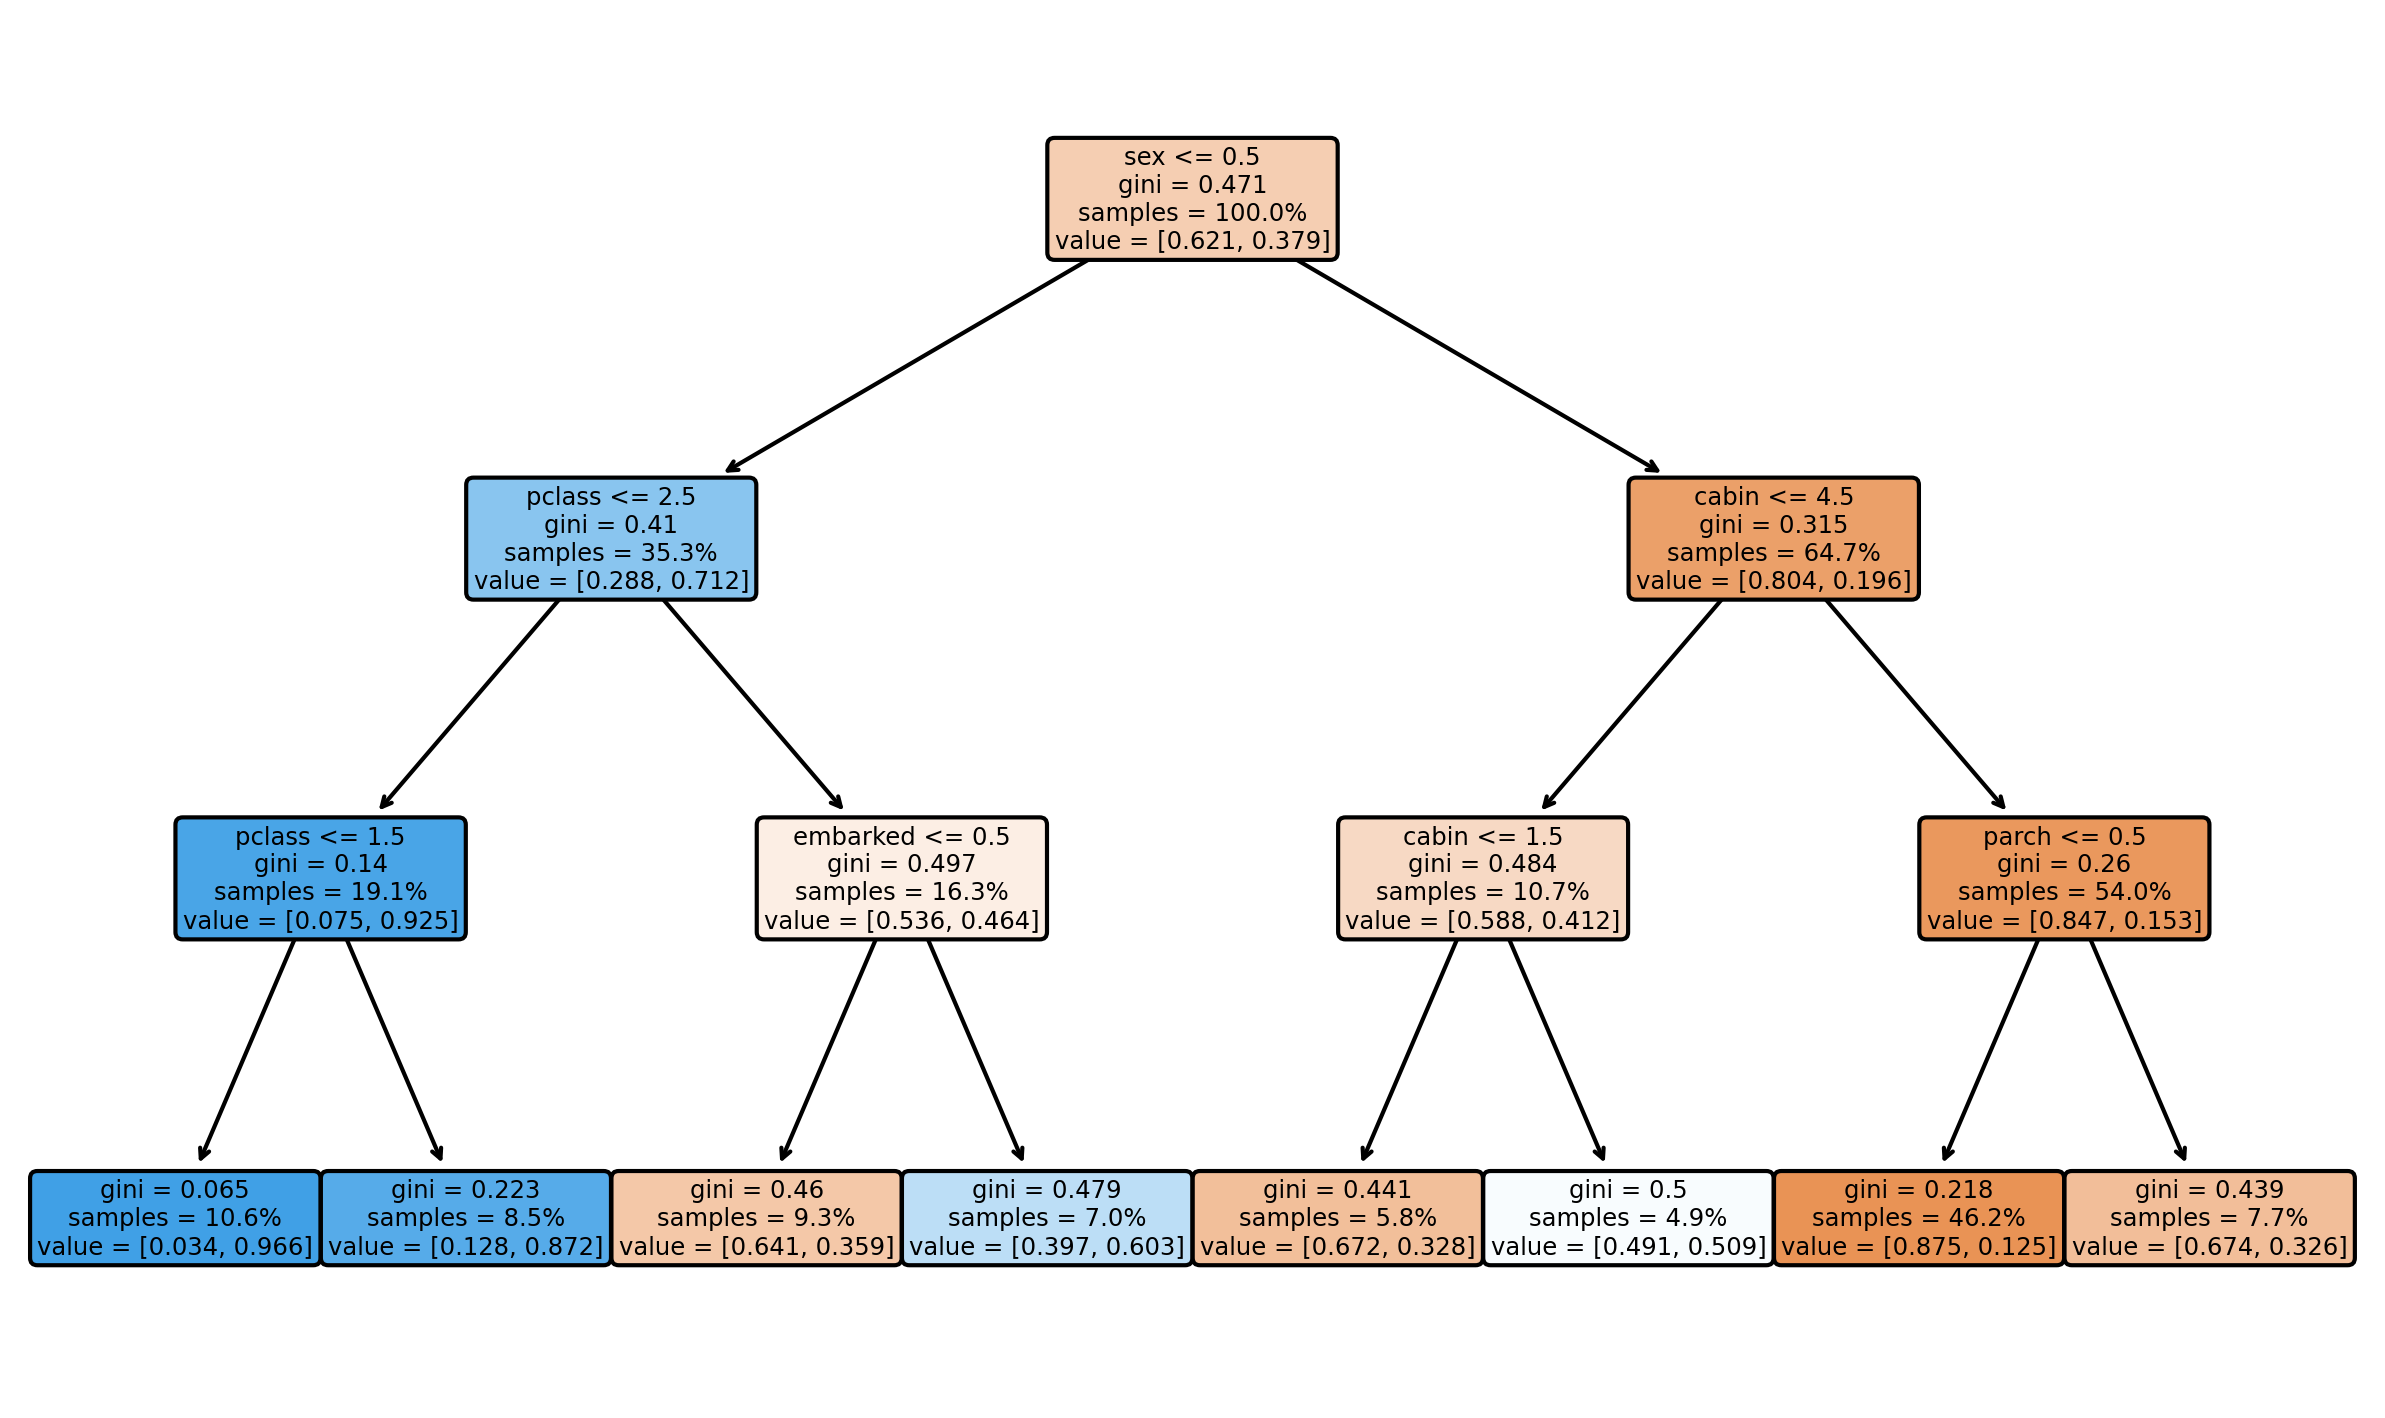

In [9]:
# Let's look at the result above in the context of the tree

plt.figure(figsize=(10, 6), dpi=300)

plot_tree(
    decision_tree = tree,
    feature_names=X_train.columns.to_list(),
    filled=True,
    rounded=True,
    proportion=True,
)

plt.show()

## Node contributions

In [10]:
first_split = 0.196 - 0.379
second_split = 0.412 - 0.196
third_split = 0.509 - 0.412

first_split, second_split, third_split

(-0.183, 0.21599999999999997, 0.09700000000000003)

In [11]:
# prediction

y_train.mean() + first_split + second_split + third_split

0.5085971223021583

## Feature contribution

In [12]:
sex = first_split
cabin = second_split + third_split

sex, cabin

(-0.183, 0.313)

In [13]:
# prediction

y_train.mean() + sex + cabin

0.5085971223021583

In [14]:
tree.predict_proba(X_test.loc[sample_id].to_frame().T)

array([[0.49090909, 0.50909091]])

I spent hours trying to see if there was an easy way to calculate feature contributions with sklearn, and I failed. So we are going to outsource the job to the tree interpreter.

## Tree interpreter

In [15]:
from treeinterpreter import treeinterpreter as ti

In [16]:
prediction, bias, contributions = ti.predict(tree, X_test)

In [17]:
# constribution for first sample

contributions[0]

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.18249142, -0.18249142],
       [ 0.        ,  0.        ],
       [-0.31298521,  0.31298521]])

In [18]:
# contribution for class = 1

contributions[0][:, 1]

array([ 0.        ,  0.        ,  0.        , -0.18249142,  0.        ,
        0.31298521])

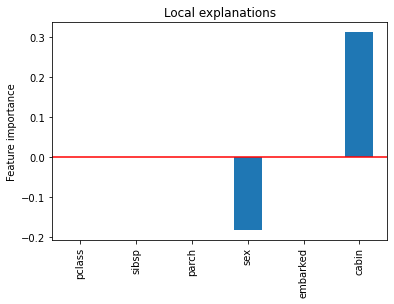

In [19]:
pd.Series(contributions[0][:, 1], index=X_train.columns).plot.bar()
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Feature importance")
plt.title("Local explanations")
plt.show()

In [20]:
prediction[0]

array([0.49090909, 0.50909091])

In [21]:
X_test.reset_index(drop=True, inplace=True)

X_test.loc[0]

pclass      1
sibsp       0
parch       0
sex         1
embarked    0
cabin       2
Name: 0, dtype: int64

Text(0.5, 1.0, 'Local explanations')

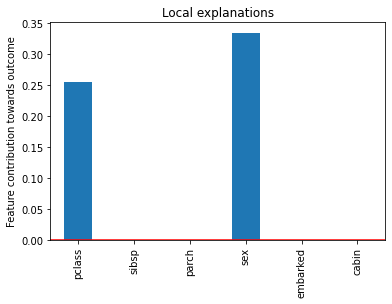

In [22]:
pd.Series(contributions[2][:, 1], index=X_train.columns).plot.bar()
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Feature contribution towards outcome")
plt.title("Local explanations")

In [23]:
prediction[2]

array([0.03389831, 0.96610169])

In [24]:
X_test.loc[2]

pclass      1
sibsp       0
parch       0
sex         0
embarked    1
cabin       0
Name: 2, dtype: int64

Text(0.5, 1.0, 'Local explanations')

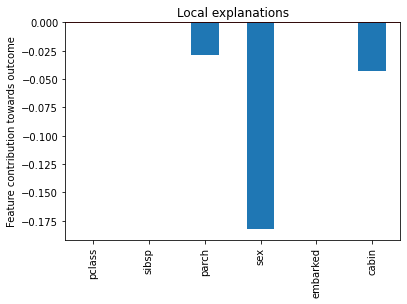

In [25]:
pd.Series(contributions[5][:, 1], index=X_train.columns).plot.bar()
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Feature contribution towards outcome")
plt.title("Local explanations")

In [26]:
prediction[5]

array([0.87548638, 0.12451362])

In [27]:
X_test.loc[5]

pclass      3
sibsp       0
parch       0
sex         1
embarked    0
cabin       5
Name: 5, dtype: int64